In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [111]:
df_initial = pd.read_csv('./data.csv',encoding='latin1',dtype={'CustomerID': str,'InvoiceID': str})
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
print('Dataframe dimensions:', df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))
print(tab_info)

Dataframe dimensions: (541909, 8)
                 InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0        1454        0               0   
null values (%)          0         0    0.268311        0               0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0     135080       0  
null values (%)          0    24.9267       0  


In [ ]:
df_initial.head()

In [112]:
# Remove entries for customer ID NULL
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))
print(tab_info)

Dataframe dimensions: (406829, 8)
                 InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)          0         0           0        0               0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0          0       0  
null values (%)          0          0       0  


In [113]:
df_initial.drop_duplicates(inplace = True)

In [114]:
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (401604, 8)


In [115]:
country_to_index = {}
count=0
countries = df_initial["Country"].to_numpy()
for i in range(countries.shape[0]):
    if countries[i] not in country_to_index:
        country_to_index[countries[i]] = count
        count+=1
print(count)
print(country_to_index)

37
{'United Kingdom': 0, 'France': 1, 'Australia': 2, 'Netherlands': 3, 'Germany': 4, 'Norway': 5, 'EIRE': 6, 'Switzerland': 7, 'Spain': 8, 'Poland': 9, 'Portugal': 10, 'Italy': 11, 'Belgium': 12, 'Lithuania': 13, 'Japan': 14, 'Iceland': 15, 'Channel Islands': 16, 'Denmark': 17, 'Cyprus': 18, 'Sweden': 19, 'Austria': 20, 'Israel': 21, 'Finland': 22, 'Greece': 23, 'Singapore': 24, 'Lebanon': 25, 'United Arab Emirates': 26, 'Saudi Arabia': 27, 'Czech Republic': 28, 'Canada': 29, 'Unspecified': 30, 'Brazil': 31, 'USA': 32, 'European Community': 33, 'Bahrain': 34, 'Malta': 35, 'RSA': 36}


In [116]:
df_initial = df_initial.drop("Country", 1)

In [ ]:
df_initial.head()

In [117]:
for i in range(countries.shape[0]):
    countries[i] = country_to_index[countries[i]]
df_initial["CountryID"] = countries
df_initial.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,1


In [118]:
df_phase2 = df_initial
df_phase2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,0
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1


In [119]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [120]:
# Grouping Rows if they belong to same invoice no and customer id
temp = df_phase2.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


In [123]:
df_cleaned = df_phase2.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_phase2.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_phase2[(df_phase2['CustomerID'] == col['CustomerID']) &
                         (df_phase2['StockCode']  == col['StockCode']) & 
                         (df_phase2['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_phase2['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)

    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        

    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break           

In [133]:
print(doubtfull_entry)
print(entry_to_remove)

[154, 235, 236, 237, 238, 239, 240, 241, 1441, 1442, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 3170, 3338, 3410, 3693, 3911, 3912, 4287, 4306, 4307, 4836, 4837, 4853, 4854, 4855, 4856, 4857, 4858, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4904, 4905, 4906, 4907, 4931, 4932, 4937, 4938, 4941, 4942, 4943, 4944, 5232, 5233, 5234, 5235, 5236, 5259, 5260, 5261, 5262, 5263, 6781, 6783, 7437, 7438, 7439, 7520, 7521, 8316, 8317, 8318, 8319, 8320, 8321, 9494, 10194, 10204, 11800, 11813, 12402, 12538, 12539, 12540, 13052, 13053, 13054, 13055, 13265, 14022, 14023, 14332, 14333, 14334, 14525, 14526, 14527, 14530, 14532, 14533, 14534, 14535, 14536, 17075, 17352, 17353, 17354, 17388, 17389, 17390, 17453, 17986, 17987, 18132, 18133, 18134, 18135, 18197, 18198, 18200, 18201, 18202, 18203, 18204, 18246, 18247, 18255, 18352, 18974, 18975, 19105, 19106, 19107, 19108, 19124, 19430, 19431, 19432, 19433, 19434, 19435, 19436, 19437, 19438, 194

In [137]:
print(df_cleaned.shape)
df_cleaned.drop(doubtfull_entry,inplace=True)
df_cleaned.drop(entry_to_remove,inplace=True)
print(df_cleaned.shape)

(401604, 9)
(392857, 9)


In [176]:
df_phase3 = df_cleaned

In [177]:
df_phase3["TotalPrice"] = df_phase3["UnitPrice"]*(df_phase3["Quantity"] - df_phase3["QuantityCanceled"])
df_phase3

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,0,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,0,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1,0,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1,0,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1,0,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1,0,16.60


In [178]:
df_phase3.to_csv("df_phase3.csv")

In [179]:
print(df_phase3.shape)

(392857, 10)


In [ ]:
temp = df_phase3.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
basket_price = basket_price[basket_price["Basket Price"]>0]
basket_price.head()

In [ ]:
df_phase4 = pd.read_csv('basket_price.csv', encoding = 'latin1')
df_phase4

In [180]:
df_phase3 = pd.read_csv('df_phase3.csv', encoding = 'latin1', dtype={'CustomerID': str,'InvoiceID': str})
df_phase3

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID,QuantityCanceled,TotalPrice
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,0,0,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,0,0,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
...,...,...,...,...,...,...,...,...,...,...,...
392852,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1,0,10.20
392853,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1,0,12.60
392854,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1,0,16.60
392855,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1,0,16.60


In [141]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lem = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /home/purnadip_chakrabarti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/purnadip_chakrabarti/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/purnadip_chakrabarti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [142]:
root_freq = {}
stock_to_roots = {}
root_to_index = {}
count = 0

def is_noun(pos):
    if pos[:2] == 'NN':
        return True
    return False


for i, row in df_phase3.iterrows():
    if pd.isnull(desc):
        continue 
    desc = row["Description"]
    desc = desc.lower()
    stock = row["StockCode"]
    tokens = nltk.word_tokenize(desc)
    nouns = [word for (word, pos) in nltk.pos_tag(tokens) if is_noun(pos)] 
    vis = {}
    temp = []
    for noun in nouns:
        noun = noun.lower()
        root = lem.lemmatize(noun)
        if root not in root_freq:
            root_freq[root] = 1
            vis[root] = 1
            temp.append(root)
            root_to_index[root] = count 
            count += 1
        elif root not in vis:
            root_freq[root] += 1
            vis[root] = 1
            temp.append(root)
    stock_to_roots[stock] = temp

print(root_freq)

{'heart': 32881, 'holder': 12592, 'metal': 12876, 'lantern': 987, 'cream': 5682, 'cupid': 247, 'coat': 1221, 'hanger': 1650, 'union': 4125, 'flag': 1375, 'water': 7432, 'bottle': 8863, 'nesting': 339, 'box': 19878, 'glass': 8521, 'star': 5084, 'hand': 4084, 'jack': 2892, 'warmer': 2686, 'dot': 93, 'bird': 4093, 'ornament': 1395, 'poppy': 1440, 'playhouse': 1091, 'bedroom': 318, 'kitchen': 2669, 'feltcraft': 6124, 'princess': 1042, 'charlotte': 4409, 'doll': 1928, 'ivory': 5677, 'cosy': 247, 'colour': 2529, 'teaspoon': 73, 'vintage': 24580, 'jigsaw': 1143, 'block': 2413, 'alphabet': 3060, 'home': 4491, 'building': 1498, 'word': 1498, 'love': 1300, 'recipe': 1911, 'england': 587, 'jam': 3760, 'jar': 4693, 'rack': 1652, 'paris': 335, 'fashion': 321, 'bath': 1118, 'alarm': 3485, 'clock': 5802, 'bakelike': 2629, 'pink': 13099, 'green': 1891, 'panda': 57, 'bunny': 1032, 'sheet': 261, 'tape': 758, 'globe': 49, 'head': 685, 'tail': 890, 'game': 1345, 'set/2': 221, 'retrospot': 24044, 'tea': 78

In [ ]:
print(root_to_index)

In [143]:
threshold = 1400
print(len(root_freq))
top_roots = {key:val for key, val in root_freq.items() if val >= threshold}
print(len(top_roots))

1500
185


In [144]:
c = 0
pop_root_to_index = {}
for key, val in top_roots.items():
    pop_root_to_index[key] = c 
    c += 1
print(pop_root_to_index)

{'heart': 0, 'holder': 1, 'metal': 2, 'cream': 3, 'hanger': 4, 'union': 5, 'water': 6, 'bottle': 7, 'box': 8, 'glass': 9, 'star': 10, 'hand': 11, 'jack': 12, 'warmer': 13, 'bird': 14, 'poppy': 15, 'kitchen': 16, 'feltcraft': 17, 'charlotte': 18, 'doll': 19, 'ivory': 20, 'colour': 21, 'vintage': 22, 'block': 23, 'alphabet': 24, 'home': 25, 'building': 26, 'word': 27, 'recipe': 28, 'jam': 29, 'jar': 30, 'rack': 31, 'alarm': 32, 'clock': 33, 'bakelike': 34, 'pink': 35, 'green': 36, 'retrospot': 37, 'tea': 38, 'towel': 39, 'round': 40, 'snack': 41, 'woodland': 42, 'spaceboy': 43, 'lunch': 44, 'i': 45, 'london': 46, 'circus': 47, 'bag': 48, 'design': 49, 'toadstool': 50, 'night': 51, 'light': 52, 'mini': 53, 'parade': 54, 'paper': 55, 'chain': 56, 'christmas': 57, 'parasol': 58, 'coffee': 59, 'mug': 60, 'wood': 61, 'drawer': 62, 'cabinet': 63, 'finish': 64, 'picture': 65, 'frame': 66, 'wooden': 67, 'polkadot': 68, 'toy': 69, 'strawberry': 70, 'piece': 71, 'cutlery': 72, 'set': 73, 'plate': 

In [ ]:
lis = df_phase3.UnitPrice.value_counts()
print(lis)

In [145]:
list_products = df_phase3["StockCode"].unique()

In [146]:
products_np = []
mean_prices = []
count_cat = [0 for _ in range(6)]
for i,stock in enumerate(list_products):
    desc = df_phase3[df_phase3["StockCode"] == stock]["Description"].iloc[0]
    temp = [stock, desc]
    roots = stock_to_roots[stock]
    t = [0 for i in range(len(top_roots))]
    for root in roots:
        if root in top_roots:
            index = pop_root_to_index[root]
            t[index] = 1
    temp.extend(t)
    mean_price = df_phase3[df_phase3["StockCode"] == stock]["UnitPrice"].mean()
    prod_cat = 0

    if mean_price < 1:
        prod_cat = 0
    elif mean_price < 2:
        prod_cat = 1
    elif mean_price < 3:
        prod_cat = 2
    elif mean_price < 5:
        prod_cat = 3
    elif mean_price < 10:
        prod_cat = 4
    else:
        prod_cat = 5

    cat_list = [0 for _ in range(6)]
    cat_list[prod_cat] = 1
    temp.extend(cat_list)
    mean_prices.append(mean_price)
    count_cat[prod_cat]+=1
    temp = np.array(temp)
    # print(temp.shape)
    products_np.append(temp)

0.00075


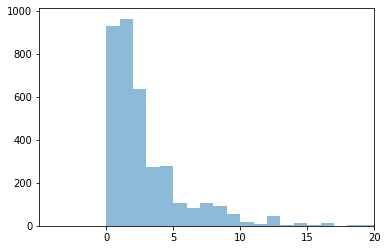

In [147]:
bins = np.arange(-100, 100, 1) # fixed bin size
print(min(mean_prices))
plt.xlim([min(mean_prices)-5, 20])

plt.hist(mean_prices, bins=bins, alpha=0.5)
plt.show()

In [148]:
count_cat = np.array(count_cat)
for i in range(6):
    print(count_cat[i]/np.sum(count_cat) * 100, "%")

25.340971085651937 %
26.29569012547736 %
17.321331151118386 %
15.057283142389524 %
11.947626841243862 %
4.037097654118931 %


In [149]:
products_np = np.array(products_np)
print(products_np.shape)

(3666, 193)


In [150]:
cols = ["StockCode","Description"]
for i in range(185):
    cols.append("root-"+str(i+1))
for i in range(6):
    cols.append("priceRange-"+str(i+1))
df_products = pd.DataFrame(products_np,columns = cols)
df_products.to_csv("df_products.csv")

In [157]:
df_inp = df_products.drop(["StockCode","Description",df_products.columns[0]],axis=1)
prod_np = df_inp.to_numpy().astype('int64')

In [158]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters = 5, n_init=1000)
kmeans.fit(prod_np)
clusters = kmeans.predict(prod_np)

print(clusters)

[4 1 1 ... 2 2 4]


In [159]:
print(pd.Series(clusters).value_counts())

0    964
2    929
4    635
3    586
1    552
dtype: int64


In [168]:
df_phase3 = pd.read_csv("df_phase3.csv",encoding="latin1")
df_phase3


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,CountryID,QuantityCanceled,TotalPrice
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,0,0,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,0,0,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,0,0,20.34
...,...,...,...,...,...,...,...,...,...,...,...
392852,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,1,0,10.20
392853,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,1,0,12.60
392854,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,1,0,16.60
392855,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,1,0,16.60


In [160]:
print(df_phase3.shape,len(clusters))

(3666, 2) 3666


In [162]:
df_phase4 = df_products[["StockCode", "Description"]]
df_phase4["Category"] = clusters
print(df_phase4 )

     StockCode                          Description  Category
0       85123A   WHITE HANGING HEART T-LIGHT HOLDER         4
1        71053                  WHITE METAL LANTERN         1
2       84406B       CREAM CUPID HEARTS COAT HANGER         1
3       84029G  KNITTED UNION FLAG HOT WATER BOTTLE         1
4       84029E       RED WOOLLY HOTTIE WHITE HEART.         1
...        ...                                  ...       ...
3661    90214U            LETTER "U" BLING KEY RING         2
3662    90214W            LETTER "W" BLING KEY RING         2
3663    90214Z            LETTER "Z" BLING KEY RING         2
3664     90089       PINK CRYSTAL SKULL PHONE CHARM         2
3665     23843          PAPER CRAFT , LITTLE BIRDIE         4

[3666 rows x 3 columns]


/home/purnadip_chakrabarti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [163]:
df_phase4.to_csv("final_prod_cat.csv")

In [165]:
stock_to_cat = {}

for i,row in df_phase4.iterrows():
    stock_to_cat[row["StockCode"]] = row["Category"]

print(stock_to_cat)

{'85123A': 4, '71053': 1, '84406B': 1, '84029G': 1, '84029E': 1, '22752': 3, '21730': 1, '22633': 4, '22632': 4, '84879': 0, '22745': 4, '22748': 4, '22749': 1, '22310': 0, '84969': 1, '22623': 3, '22622': 3, '21754': 3, '21755': 3, '21777': 3, '48187': 3, '22960': 1, '22913': 1, '22912': 1, '22914': 1, '21756': 3, '22728': 1, '22727': 1, '22726': 1, '21724': 2, '21883': 2, '10002': 2, '21791': 0, '21035': 1, '22326': 4, '22629': 0, '22659': 0, '22631': 0, '22661': 2, '21731': 0, '22900': 1, '21913': 1, '22540': 2, '22544': 2, '22492': 2, 'POST': 3, '22086': 4, '20679': 3, '37370': 0, '21871': 0, '21071': 0, '21068': 0, '82483': 3, '82486': 3, '82482': 4, '82494L': 4, '21258': 3, '22114': 1, '21733': 4, '22386': 4, '85099C': 4, '21033': 4, '20723': 2, '84997B': 1, '84997C': 1, '21094': 2, '20725': 0, '21559': 4, '22352': 4, '21212': 2, '21975': 2, '21977': 2, '84991': 2, '84519A': 0, '85183B': 0, '85071B': 2, '21931': 4, '21929': 4, '22961': 0, '22139': 1, '84854': 1, '22411': 4, '8256

In [167]:
print(df_phase3)

     StockCode                          Description
0       85123A   WHITE HANGING HEART T-LIGHT HOLDER
1        71053                  WHITE METAL LANTERN
2       84406B       CREAM CUPID HEARTS COAT HANGER
3       84029G  KNITTED UNION FLAG HOT WATER BOTTLE
4       84029E       RED WOOLLY HOTTIE WHITE HEART.
...        ...                                  ...
3661    90214U            LETTER "U" BLING KEY RING
3662    90214W            LETTER "W" BLING KEY RING
3663    90214Z            LETTER "Z" BLING KEY RING
3664     90089       PINK CRYSTAL SKULL PHONE CHARM
3665     23843          PAPER CRAFT , LITTLE BIRDIE

[3666 rows x 2 columns]


In [181]:
for i,row in df_phase3.iterrows():
    df_phase3.iloc[i]["prod_cat"] = stock_to_cat[row["StockCode"]]

print(df_phase3)

/home/purnadip_chakrabarti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/purnadip_chakrabarti/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


KeyboardInterrupt: 

In [170]:
stock_list = df_phase3["StockCode"].to_numpy()
cat_list = []
for i in range(stock_list.shape[0]):
    cat_list.append(stock_to_cat[stock_list[i]])

df_phase3["prod_cat"] = cat_list

In [ ]:
print(df_phase3)

In [171]:
df_phase3_np = df_phase3.to_numpy()

In [172]:
df_phase7_np = []
for i in range(df_phase3_np.shape[0]):
    temp = [0,0,0,0,0]
    cat = df_phase3_np[i][-1]
    temp[cat] = df_phase3_np[i][-6]*(df_phase3_np[i][-8] - df_phase3_np[i][-3])
    res = list(df_phase3_np[i]) + temp
    df_phase7_np.append(np.array(res))

df_phase7_np = np.array(df_phase7)
print(df_phase7_np)

[['0' '536365' '85123A' ... '15.299999999999999' '0' '0']
 ['1' '536365' '71053' ... '0' '0' '20.34']
 ['2' '536365' '84406B' ... '0' '0' '22.0']
 ...
 ['541906' '581587' '23254' ... '0' '0' '16.6']
 ['541907' '581587' '23255' ... '0' '0' '16.6']
 ['541908' '581587' '22138' ... '0' '0' '14.850000000000001']]


In [173]:
cols = list(df_phase3.columns)
cols.extend(["cat0","cat1","cat2","cat3","cat4"])
df_phase7 = pd.DataFrame(df_phase7_np,columns=cols)
print(df_phase7)

       Unnamed: 0 InvoiceNo StockCode                          Description  \
0               0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1               1    536365     71053                  WHITE METAL LANTERN   
2               2    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3               3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4               4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
...           ...       ...       ...                                  ...   
401599     541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS   
401600     541905    581587     22899         CHILDREN'S APRON DOLLY GIRL    
401601     541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL    
401602     541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE   
401603     541908    581587     22138        BAKING SET 9 PIECE RETROSPOT    

       Quantity          InvoiceDate UnitPrice CustomerID Count

In [174]:
for i,row in df_phase7.iterrows():
    if row["StockCode"][0] == "C":
        print('here')

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
